In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [130]:
# Загрузка и подготовка данных
data = pd.read_csv('BTC1d.csv', delimiter=',', parse_dates=True)
data = data.rename(columns={'Open time': 'Date'})
data = data.drop(['Close time', 'Quote asset volume', 'Number of trades',
                  'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'], axis=1)

data['Date'] = data['Date'].str.split(' ').str[0]
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data.set_index('Date', inplace=True)

# Фильтруем данные для периода
data_filtered = data[(data.index >= '2020-09-01') & (data.index < '2024-01-01')]
print(data_filtered)

                Open      High       Low     Close         Volume
Date                                                             
2020-09-01  11649.51  12050.85  11515.00  11921.97   78148.193668
2020-09-02  11921.97  11954.57  11160.10  11388.54   87221.845602
2020-09-03  11388.54  11462.60   9960.80  10140.85  121950.106015
2020-09-04  10138.29  10627.05   9875.50  10446.25   92733.599113
2020-09-05  10446.25  10565.68   9825.00  10166.69   90001.605568
...              ...       ...       ...       ...            ...
2023-12-27  42508.93  43677.00  42098.69  43428.85   36191.211360
2023-12-28  43428.86  43787.57  42241.79  42563.76   35150.524850
2023-12-29  42563.76  43111.00  41300.00  42066.95   42597.189120
2023-12-30  42066.94  42612.32  41520.30  42140.28   22906.578180
2023-12-31  42140.29  42899.00  41965.84  42283.58   23585.916030

[1217 rows x 5 columns]


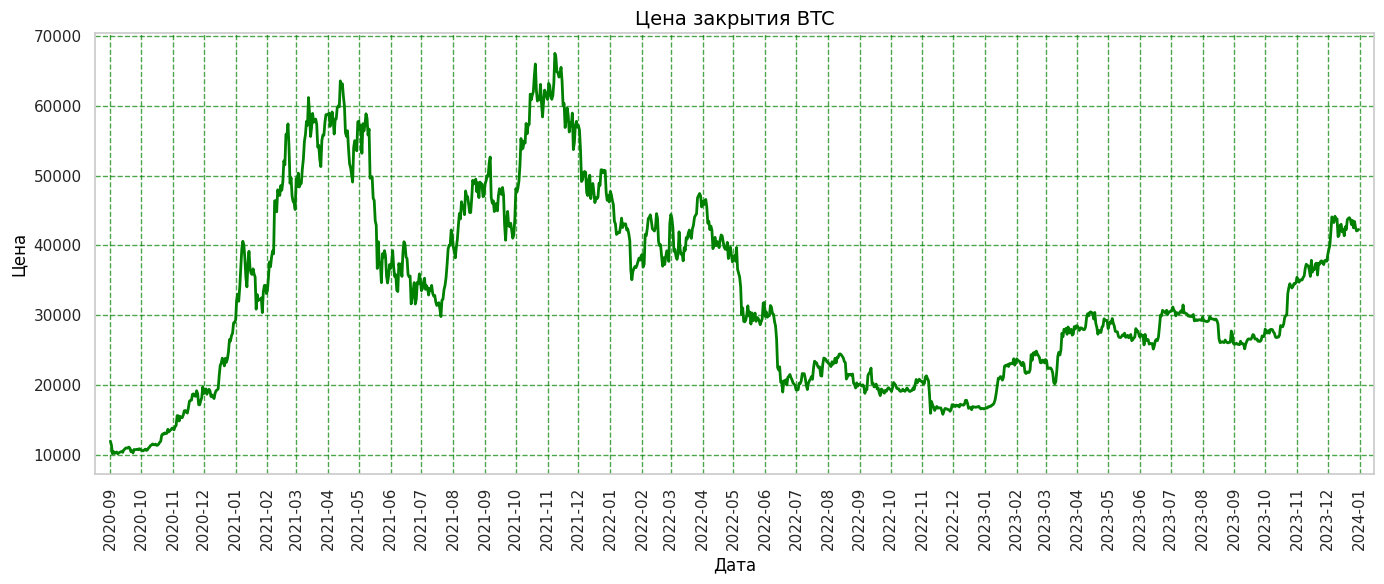

In [137]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(data_filtered.index, data_filtered["Close"], color='green', linewidth=2)  # Зеленый цвет

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax.set_xlim(data_filtered.index[0] - pd.Timedelta(days=15), data_filtered.index[-1] + pd.Timedelta(days=15))

ax.set_xlabel("Дата", fontsize=12, color='black')
ax.set_ylabel("Цена", fontsize=12, color='black')
ax.set_title("Цена закрытия BTC", fontsize=14, color='black')

fig.autofmt_xdate()

plt.xticks(rotation=90, ha='center')

ax.grid(True, linestyle='--', alpha=0.7, color='green')

plt.tight_layout()

plt.show()

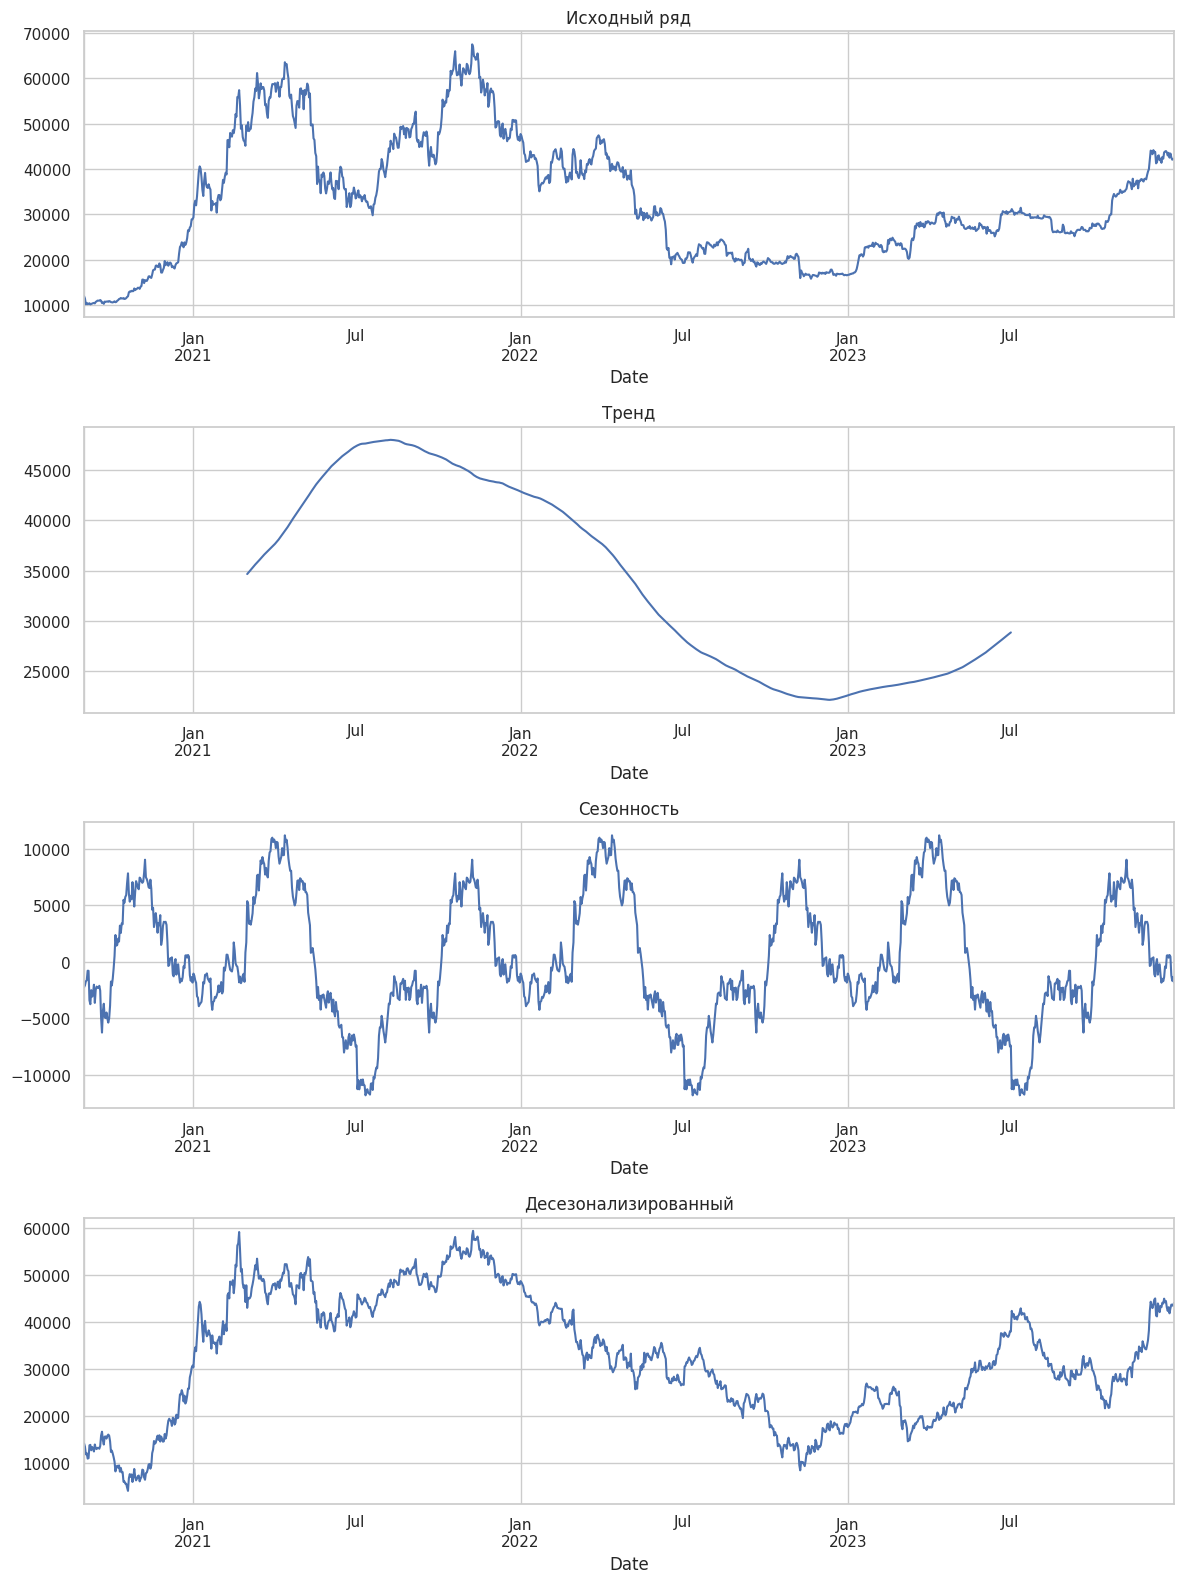

In [157]:
# decomposition = sm.tsa.seasonal_decompose(data_filtered['Close'], model='additive', period=365)
decomposition = seasonal_decompose(data_filtered['Close'], model='additive',period=365)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))

decomposition.observed.plot(ax=ax1)
ax1.set_title('Исходный ряд')

decomposition.trend.plot(ax=ax2)
ax2.set_title('Тренд')

decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Сезонность')

deseasonal = decomposition.observed-decomposition.seasonal
deseasonal.plot(ax=ax4)
ax4.set_title('Десезонализированный')

plt.tight_layout()
plt.show()

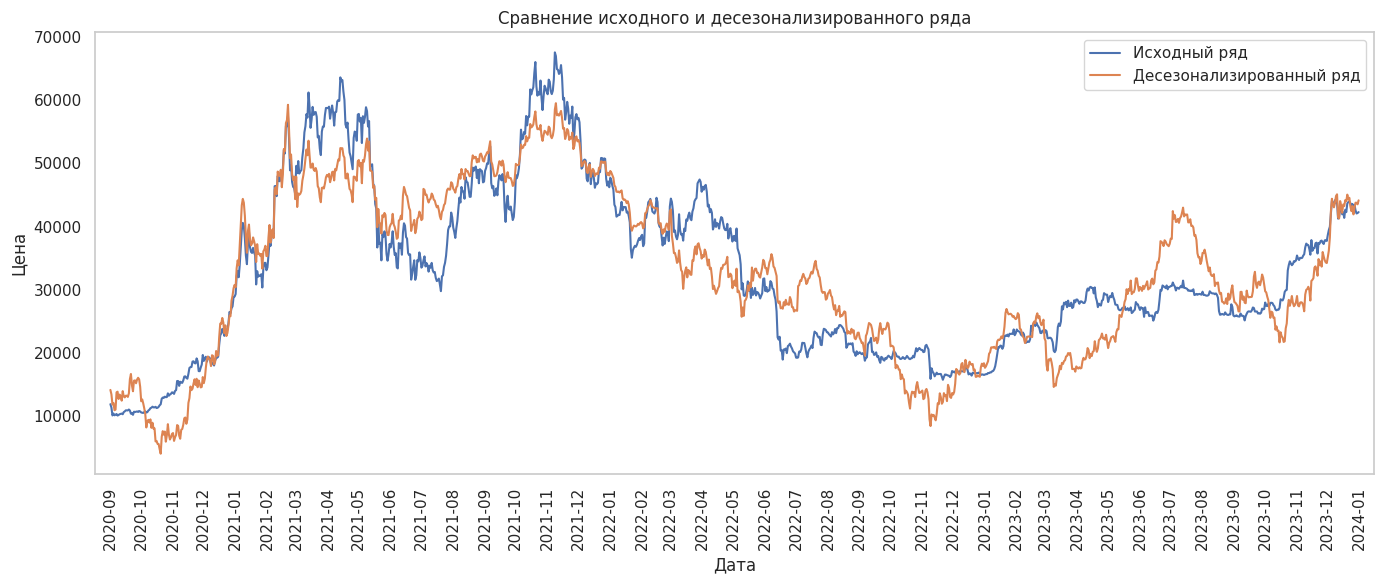

In [158]:
# Десезонализация данных
seasonal = decomposition.seasonal.dropna()
deseasonalized = decomposition.observed - seasonal

plt.figure(figsize=(14, 6))
plt.plot(data_filtered["Close"], label='Исходный ряд')
plt.plot(deseasonalized, label='Десезонализированный ряд')
plt.legend()
plt.title('Сравнение исходного и десезонализированного ряда')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().set_xlim(data_filtered.index[0]-pd.Timedelta(days=15), data_filtered.index[-1]+pd.Timedelta(days=15))
plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.grid()
plt.show()

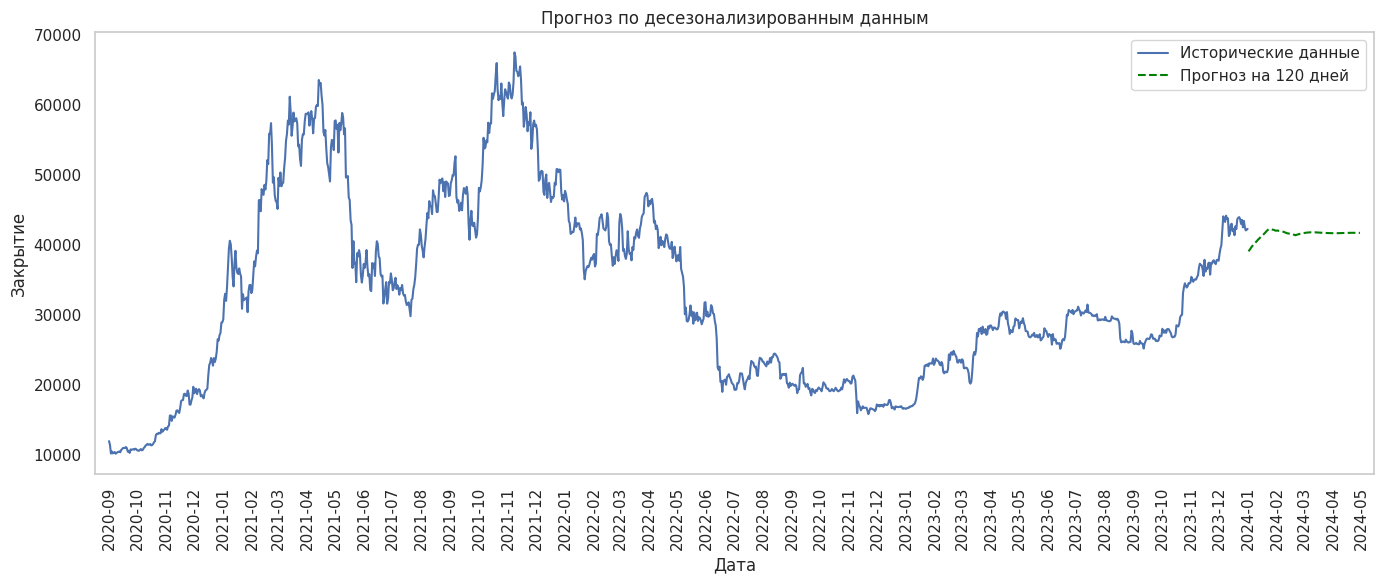

In [161]:
# Прогноз на 120 дней с использованием скользящего среднего (EMA)
window_size = 50
ema_deseasonalized = deseasonalized.ewm(span=window_size).mean()
forecast_days = 120
last_known_date = data_filtered.index[-1]
future_dates = [last_known_date + pd.Timedelta(days=i) for i in range(1, forecast_days + 1)]

future_ema_deseasonalized = []
last_values = deseasonalized[-window_size:].tolist()
for i in range(forecast_days):
    future_value = np.mean(last_values)
    future_ema_deseasonalized.append(future_value)
    last_values.pop(0)
    last_values.append(future_value)

future_df_deseasonalized = pd.DataFrame(data=future_ema_deseasonalized, index=future_dates, columns=['Forecast'])

plt.figure(figsize=(14, 6))
plt.plot(data_filtered.index, data_filtered["Close"], label='Исторические данные')
plt.plot(future_df_deseasonalized - 6, label='Прогноз на 120 дней', color='green', linestyle='dashed')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().set_xlim(data_filtered.index[0]-pd.Timedelta(days=15), future_dates[-1]+pd.Timedelta(days=15))
plt.xlabel("Дата")
plt.ylabel("Закрытие")
plt.title("Прогноз по десезонализированным данным")
plt.legend()
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90, ha="center")
plt.tight_layout()
plt.grid()
plt.show()

In [162]:
# Оценка точности прогноза
true_values = data_filtered["Close"][-forecast_days:]
forecast_values = future_df_deseasonalized.values
mae = mean_absolute_error(true_values, forecast_values)
rmse = np.sqrt(mean_squared_error(true_values, forecast_values))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 8162.66505818355
RMSE: 9880.68072108819


In [163]:
# Тест на стационарность (ADF тест)
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

adf_test(deseasonalized)

ADF Statistic: -1.9575599815876783
p-value: 0.3054857951339427
Critical Values:
	1%: -3.43577938005948
	5%: -2.863937543790164
	10%: -2.568046493171221


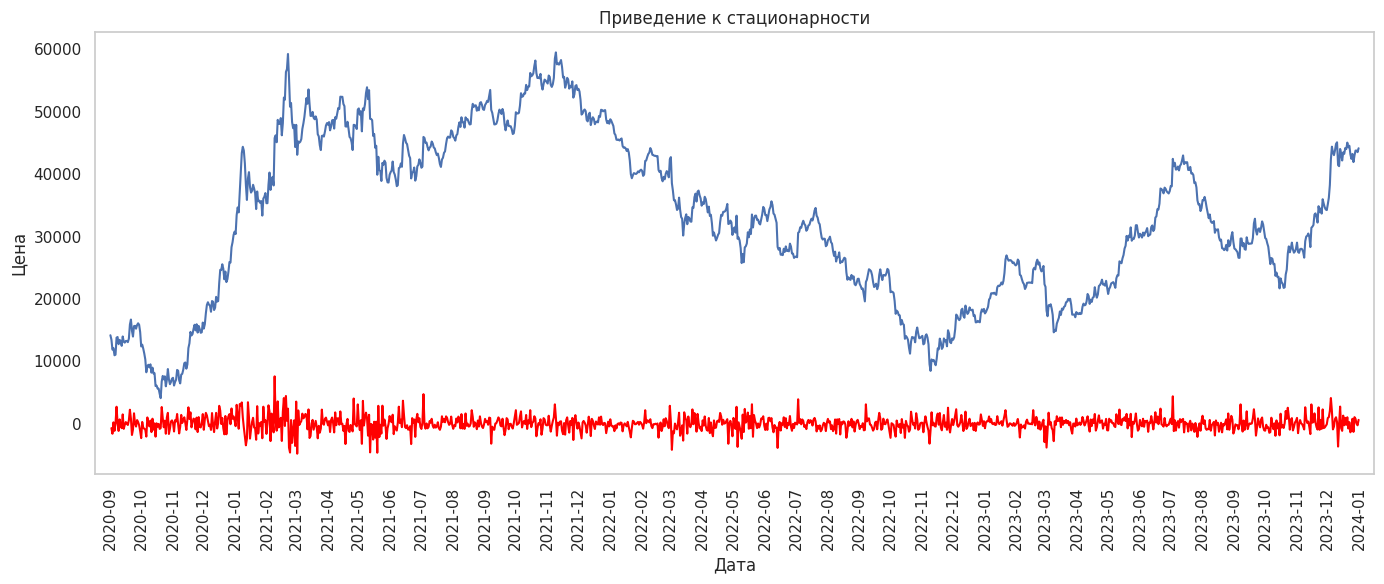

ADF Statistic: -10.81705958799085
p-value: 1.845701788187903e-19
Critical Values:
	1%: -3.43577938005948
	5%: -2.863937543790164
	10%: -2.568046493171221


In [164]:
# Приведение ряда к стационарности (дифференцирование)
detrended_data = deseasonalized.diff().dropna()

plt.figure(figsize=(14, 6))
plt.plot(deseasonalized.index, deseasonalized, label="Исходные значения")
plt.plot(detrended_data, color="red", label="Дифференцированные значения")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().set_xlim(data_filtered.index[0]-pd.Timedelta(days=15), data_filtered.index[-1]+pd.Timedelta(days=15))
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("Приведение к стационарности")
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.grid()
plt.show()

adf_test(detrended_data)

In [165]:
# Оценка модели ARIMA
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.7)
    train, test = X[:train_size], X[train_size:]

    model = ARIMA(train, order=arima_order, trend='ct')
    model_fit = model.fit()

    forecast = model_fit.forecast(steps=len(test))

    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))

    return mae, rmse

In [166]:
# Настройка параметров ARIMA
p_values = range(0, 10)
d_values = [0]
q_values = [0]

detrended_data.index = pd.date_range(start=detrended_data.index[0], periods=len(detrended_data), freq='D')

best_score_ar, best_cfg_ar = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(detrended_data.values, order)
                if mae < best_score_ar:
                    best_score_ar, best_cfg_ar = mae, order
                print(f'AR{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель AR{best_cfg_ar} MAE={best_score_ar:.3f}')

AR(0, 0, 0) MAE=756.691 RMSE=1045.849
AR(1, 0, 0) MAE=756.605 RMSE=1045.809
AR(2, 0, 0) MAE=756.584 RMSE=1045.803
AR(3, 0, 0) MAE=756.609 RMSE=1045.809
AR(4, 0, 0) MAE=756.616 RMSE=1045.811
AR(5, 0, 0) MAE=756.556 RMSE=1045.773
AR(6, 0, 0) MAE=756.350 RMSE=1045.677
AR(7, 0, 0) MAE=757.210 RMSE=1046.371
AR(8, 0, 0) MAE=757.528 RMSE=1046.642
AR(9, 0, 0) MAE=756.755 RMSE=1046.281
Лучшая модель AR(6, 0, 0) MAE=756.350


In [167]:
# Оценка модели MA
p_values = [0]
d_values = [0]
q_values = range(0, 10)

detrended_data.index = pd.date_range(start=detrended_data.index[0], periods=len(detrended_data), freq='D')

best_score_ma, best_cfg_ma = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(detrended_data.values, order)
                if mae < best_score_ma:
                    best_score_ma, best_cfg_ma = mae, order
                print(f'MA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель MA{best_cfg_ma} MAE={best_score_ma:.3f}')

MA(0, 0, 0) MAE=756.691 RMSE=1045.849
MA(0, 0, 1) MAE=756.619 RMSE=1045.818
MA(0, 0, 2) MAE=756.579 RMSE=1045.802
MA(0, 0, 3) MAE=756.632 RMSE=1045.821
MA(0, 0, 4) MAE=756.638 RMSE=1045.823
MA(0, 0, 5) MAE=756.534 RMSE=1045.757
MA(0, 0, 6) MAE=756.481 RMSE=1045.729
MA(0, 0, 7) MAE=757.357 RMSE=1046.646
MA(0, 0, 8) MAE=757.391 RMSE=1046.677
MA(0, 0, 9) MAE=756.280 RMSE=1046.037
Лучшая модель MA(0, 0, 9) MAE=756.280


In [168]:
p_values = range(0, 5)
d_values = [0]
q_values = range(0, 5)

detrended_data.index = pd.date_range(start=detrended_data.index[0], periods=len(detrended_data), freq='D')

best_score_arma, best_cfg_arma = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(detrended_data.values, order)
                if mae < best_score_arma:
                    best_score_arma, best_cfg_arma = mae, order
                print(f'ARMA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель ARMA{best_cfg_arma} MAE={best_score_arma:.3f}')

ARMA(0, 0, 0) MAE=756.691 RMSE=1045.849
ARMA(0, 0, 1) MAE=756.619 RMSE=1045.818
ARMA(0, 0, 2) MAE=756.579 RMSE=1045.802
ARMA(0, 0, 3) MAE=756.632 RMSE=1045.821
ARMA(0, 0, 4) MAE=756.638 RMSE=1045.823
ARMA(1, 0, 0) MAE=756.605 RMSE=1045.809
ARMA(1, 0, 1) MAE=756.592 RMSE=1045.804
ARMA(1, 0, 2) MAE=756.493 RMSE=1045.734
ARMA(1, 0, 3) MAE=756.565 RMSE=1045.809
ARMA(1, 0, 4) MAE=756.641 RMSE=1045.821
ARMA(2, 0, 0) MAE=756.584 RMSE=1045.803


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(2, 0, 1) MAE=756.494 RMSE=1045.739
ARMA(2, 0, 2) MAE=758.617 RMSE=1046.654


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(2, 0, 3) MAE=758.391 RMSE=1046.535
ARMA(2, 0, 4) MAE=756.420 RMSE=1046.366
ARMA(3, 0, 0) MAE=756.609 RMSE=1045.809
ARMA(3, 0, 1) MAE=756.539 RMSE=1045.746
ARMA(3, 0, 2) MAE=781.856 RMSE=1069.555


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(3, 0, 3) MAE=758.674 RMSE=1046.709
ARMA(3, 0, 4) MAE=756.337 RMSE=1046.353
ARMA(4, 0, 0) MAE=756.616 RMSE=1045.811
ARMA(4, 0, 1) MAE=756.617 RMSE=1045.814


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(4, 0, 2) MAE=756.638 RMSE=1045.847


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(4, 0, 3) MAE=758.582 RMSE=1046.759
ARMA(4, 0, 4) MAE=752.076 RMSE=1041.342
Лучшая модель ARMA(4, 0, 4) MAE=752.076


In [169]:
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

detrended_data.index = pd.date_range(start=detrended_data.index[0], periods=len(detrended_data), freq='D')

best_score_arima, best_cfg_arima = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(detrended_data.values, order)
                if mae < best_score_arima:
                    best_score_arima, best_cfg_arima = mae, order
                print(f'ARIMA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель ARIMA{best_cfg_arima} MAE={best_score_arima:.3f}')

ARIMA(0, 0, 0) MAE=756.691 RMSE=1045.849
ARIMA(0, 0, 1) MAE=756.619 RMSE=1045.818
ARIMA(0, 0, 2) MAE=756.579 RMSE=1045.802
ARIMA(1, 0, 0) MAE=756.605 RMSE=1045.809
ARIMA(1, 0, 1) MAE=756.592 RMSE=1045.804
ARIMA(1, 0, 2) MAE=756.493 RMSE=1045.734
ARIMA(2, 0, 0) MAE=756.584 RMSE=1045.803


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 0, 1) MAE=756.494 RMSE=1045.739
ARIMA(2, 0, 2) MAE=758.617 RMSE=1046.654
Лучшая модель ARIMA(1, 0, 2) MAE=756.493


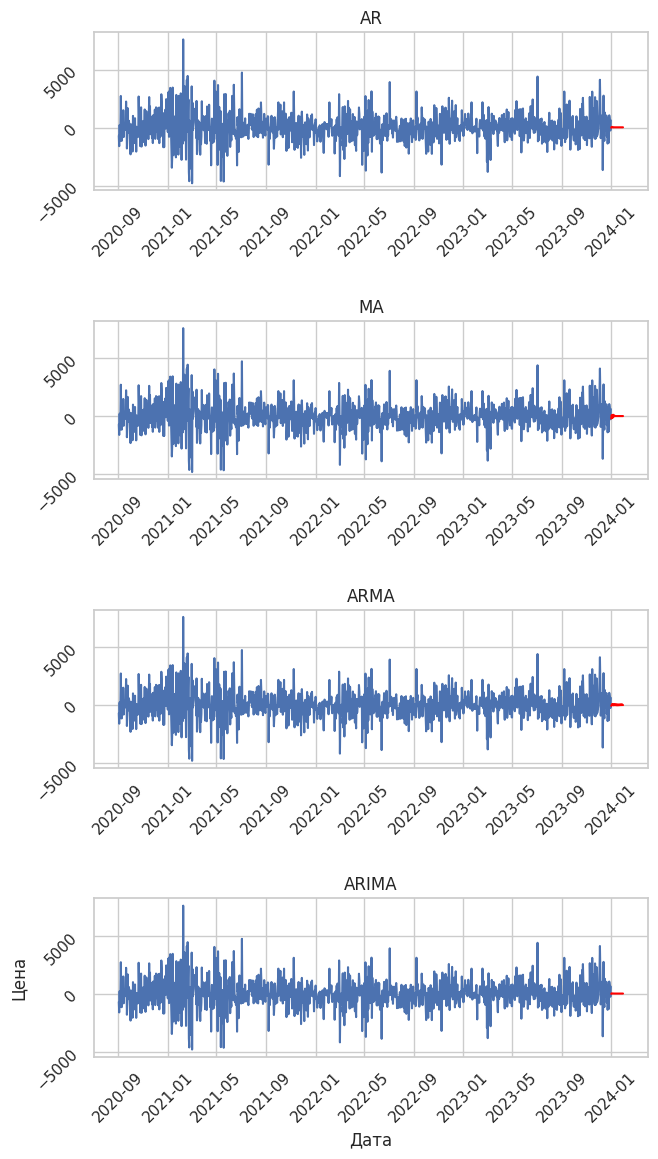

In [170]:
model_ar = ARIMA(detrended_data, order=best_cfg_ar)
model_ma = ARIMA(detrended_data, order=best_cfg_ma)
model_arma = ARIMA(detrended_data, order=best_cfg_arma)
model_arima = ARIMA(detrended_data, order=best_cfg_arima)

model_fit_ar = model_ar.fit()
model_fit_ma = model_ma.fit()
model_fit_arma = model_arma.fit()
model_fit_arima = model_arima.fit()
forecast_ar = model_fit_ar.forecast(steps=30)
forecast_ma = model_fit_ma.forecast(steps=30)
forecast_arma = model_fit_arma.forecast(steps=30)
forecast_arima = model_fit_arima.forecast(steps=30)

fig,ax = plt.subplots(4)
fig.tight_layout()
fig.set_figheight(12)
ax[0].plot(detrended_data.index, detrended_data, label='Исторические данные')
ax[1].plot(detrended_data.index, detrended_data, label='Исторические данные')
ax[2].plot(detrended_data.index, detrended_data, label='Исторические данные')
ax[3].plot(detrended_data.index, detrended_data, label='Исторические данные')
ax[0].plot(forecast_ar.index, forecast_ar, color='red', label='Прогноз')
ax[1].plot(forecast_ma.index, forecast_ma, color='red', label='Прогноз')
ax[2].plot(forecast_arma.index, forecast_arma, color='red', label='Прогноз')
ax[3].plot(forecast_arima.index, forecast_arima, color='red', label='Прогноз')
ax[0].title.set_text("AR")
ax[1].title.set_text("MA")
ax[2].title.set_text("ARMA")
ax[3].title.set_text("ARIMA")
plt.xlabel('Дата')
plt.ylabel('Цена')
ax[0].tick_params(labelrotation=45)
ax[1].tick_params(labelrotation=45)
ax[2].tick_params(labelrotation=45)
ax[3].tick_params(labelrotation=45)
plt.show()

In [171]:
test_data = detrended_data[-30:]

forecast_ar_values = forecast_ar.values
forecast_ma_values = forecast_ma.values
forecast_arma_values = forecast_arma.values
forecast_arima_values = forecast_arima.values

metrics = {
    "Model": ["AR", "MA", "ARMA", "ARIMA"],
    "MAE": [
        mean_absolute_error(test_data, forecast_ar_values),
        mean_absolute_error(test_data, forecast_ma_values),
        mean_absolute_error(test_data, forecast_arma_values),
        mean_absolute_error(test_data, forecast_arima_values),
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(test_data, forecast_ar_values)),
        np.sqrt(mean_squared_error(test_data, forecast_ma_values)),
        np.sqrt(mean_squared_error(test_data, forecast_arma_values)),
        np.sqrt(mean_squared_error(test_data, forecast_arima_values)),
    ],
    "MAPE": [
        mean_absolute_percentage_error(test_data, forecast_ar_values),
        mean_absolute_percentage_error(test_data, forecast_ma_values),
        mean_absolute_percentage_error(test_data, forecast_arma_values),
        mean_absolute_percentage_error(test_data, forecast_arima_values),
    ],
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

   Model          MAE         RMSE      MAPE
0     AR  1087.290388  1442.037297  1.114095
1     MA  1105.807969  1459.722075  1.130349
2   ARMA  1091.219416  1443.279000  1.263623
3  ARIMA  1087.819048  1444.291140  1.113406
